### Using 10 Single Neuron Perceptrons to classify MNIST Digits in a One Vs Rest scheme

#### Sandupal Dutta

### This is the Pytorch version of the code. Attempted to get better accuracies.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

In [27]:
from mlxtend.data import loadlocal_mnist

In [28]:
path = 'C:/Users/dutts/OneDrive - Johns Hopkins/Documents/DL'

In [29]:
X_train, y_train = loadlocal_mnist(
    images_path = 'C:/Users/dutts/OneDrive - Johns Hopkins/Documents/DL/MNIST/train-images-idx3-ubyte/train-images.idx3-ubyte',
    labels_path = 'C:/Users/dutts/OneDrive - Johns Hopkins/Documents/DL/MNIST/train-labels-idx1-ubyte/train-labels.idx1-ubyte'
)

In [30]:
scaler = StandardScaler()
X_train = X_train[:20000,:]
X_train = scaler.fit_transform(X_train)
y_train = y_train[:20000]

In [31]:
# X_train_ones = np.ones((X_train.shape[0], 1))
# X_train = np.hstack((X_train_ones, X_train))

In [32]:
X_test, y_test = loadlocal_mnist(
    images_path = 'C:/Users/dutts/OneDrive - Johns Hopkins/Documents/DL/MNIST/t10k-images-idx3-ubyte/t10k-images.idx3-ubyte',
    labels_path = 'C:/Users/dutts/OneDrive - Johns Hopkins/Documents/DL/MNIST/t10k-labels-idx1-ubyte/t10k-labels.idx1-ubyte'
)

In [33]:
X_test = X_test[:2000,:]
X_test = scaler.transform(X_test)
y_test = y_test[:2000]

In [34]:
# X_test_ones = np.ones((X_test.shape[0], 1))
# X_test = np.hstack((X_test_ones, X_test))

In [35]:
# print('Dimensions: %s x %s' % (X_train.shape[0], X_train.shape[1]))
# print('\n1st row', X_train[0])

In [36]:
print('Digits:  0 1 2 3 4 5 6 7 8 9')
print('labels: %s' % np.unique(y_train))
print('Class distribution: %s' % np.bincount(y_train))

Digits:  0 1 2 3 4 5 6 7 8 9
labels: [0 1 2 3 4 5 6 7 8 9]
Class distribution: [1994 2281 1929 2076 1945 1775 1971 2093 1922 2014]


In [37]:
# # Store as csv
# np.savetxt(fname='train_images.csv', 
#            X=X_train, delimiter=',', fmt='%d')
# np.savetxt(fname='train_labels.csv', 
#            X=y_train, delimiter=',', fmt='%d')

In [38]:
# np.savetxt(fname='test_images.csv', 
#            X=X_test, delimiter=',', fmt='%d')
# np.savetxt(fname='test_labels.csv', 
#            X=y_test, delimiter=',', fmt='%d')

In [39]:
# plt.matshow(X_train[0].reshape(28,28)) 

In [40]:
train_x = torch.FloatTensor(X_train)
train_y = torch.LongTensor(y_train)
test_x = torch.FloatTensor(X_test)
test_y = torch.LongTensor(y_test)

In [41]:
print(X_train.shape, y_train.shape)

(20000, 784) (20000,)


In [42]:
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [43]:
# Data loader
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=100,
                            shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                           batch_size=100,
                           shuffle=False)

#### 2. Part 2

#### Perceptron with step function

In [19]:
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.weights = nn.Parameter(0.01 * torch.randn(785))

    def forward(self, x):
        return torch.sign(torch.matmul(x, self.weights)) # step function

    def loss(self, x, y):
        """ Perceptron loss: max(0, -y * (w . x))"""
        return torch.clamp(-y * torch.matmul(x, self.weights), min=0).mean()

In [20]:
def train_perceptron(model, train_x, train_y, test_x, test_y, epochs=1000, lr=0.01):
    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        y_pred = torch.sign(torch.matmul(train_x, model.weights))
        # Identify misclassified samples
        # misclassified = (y_pred != train_y)
        misclassified = (y_pred * train_y <= 0)

        if misclassified.any():
            # vectorized weight update: W = W + lr * (X_misclassified.T @ Y_misclassified)
            model.weights.data += lr * torch.matmul(train_x[misclassified].T, train_y[misclassified])

        # Compute training and testing loss
        train_loss = model.loss(train_x, train_y).item()
        test_loss = model.loss(test_x, test_y).item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if (epoch + 1) % 100 == 1:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses       
    

In [21]:
def test_perceptron(model, test_x, test_y):
    y_pred = torch.sign(torch.matmul(test_x, model.weights))
    accuracy = (y_pred == test_y).float().mean().item()
    return accuracy

In [ ]:
# Train and test 10 perceptrons (one for each digit)
accuracies = {}
loss_curves = {}
model = {}

train_x = torch.cat((torch.ones(train_x.size(0), 1), train_x), dim=1)
test_x = torch.cat((torch.ones(test_x.size(0), 1), test_x), dim=1)


for digit in range(10):
    print(f"Training perceptron for digit {digit}...")

    # Convert labels to binary (+1 for target digit, -1 for others)
    train_y_bin = torch.where(train_y == digit, torch.tensor(1.0), torch.tensor(-1.0))
    test_y_bin  = torch.where(test_y == digit, torch.tensor(1.0), torch.tensor(-1.0))

    perceptron = Perceptron()

    train_losses, test_losses = train_perceptron(perceptron, train_x, train_y_bin, test_x, test_y_bin, epochs=1000, lr=0.01)
    acc = test_perceptron(perceptron, test_x, test_y_bin)

    accuracies[digit] = acc
    loss_curves[digit] = (train_losses, test_losses)
    model[digit] = perceptron    

Training perceptron for digit 0...
Epoch 1/1000, Train Loss: 250.1214, Test Loss: 237.5536
Epoch 101/1000, Train Loss: 0.2448, Test Loss: 1.0552
Epoch 201/1000, Train Loss: 0.1420, Test Loss: 1.0719
Epoch 301/1000, Train Loss: 0.3101, Test Loss: 1.6475
Epoch 401/1000, Train Loss: 0.1428, Test Loss: 1.6032
Epoch 501/1000, Train Loss: 0.1112, Test Loss: 1.5702
Epoch 601/1000, Train Loss: 0.1076, Test Loss: 1.5740
Epoch 701/1000, Train Loss: 0.0667, Test Loss: 1.5248
Epoch 801/1000, Train Loss: 0.0501, Test Loss: 1.5260
Epoch 901/1000, Train Loss: 0.0491, Test Loss: 1.5820
Training perceptron for digit 1...
Epoch 1/1000, Train Loss: 563.0652, Test Loss: 713.3201
Epoch 101/1000, Train Loss: 0.6164, Test Loss: 0.7401
Epoch 201/1000, Train Loss: 0.3751, Test Loss: 0.7451
Epoch 301/1000, Train Loss: 0.1791, Test Loss: 0.7147
Epoch 401/1000, Train Loss: 0.3695, Test Loss: 0.8073
Epoch 501/1000, Train Loss: 0.2272, Test Loss: 0.8463
Epoch 601/1000, Train Loss: 0.1422, Test Loss: 0.8586
Epoch 70

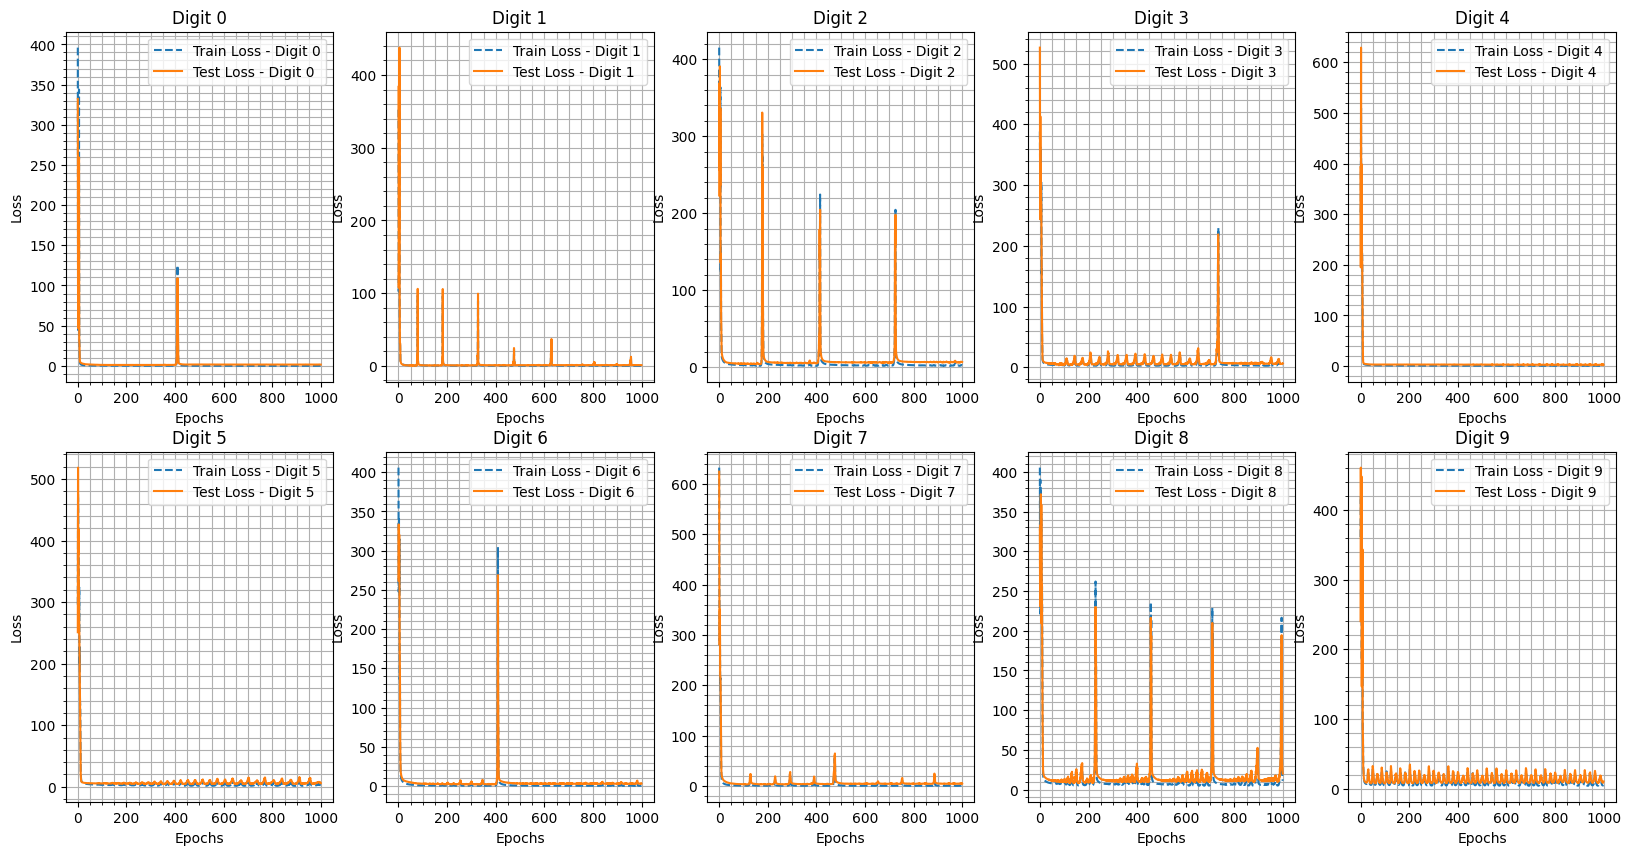

Final test accuracies: {0: 0.9819999933242798, 1: 0.9894999861717224, 2: 0.965499997138977, 3: 0.9624999761581421, 4: 0.9769999980926514, 5: 0.9589999914169312, 6: 0.9764999747276306, 7: 0.9585000276565552, 8: 0.9415000081062317, 9: 0.9474999904632568}


In [23]:
# Plot training and testing loss curves
fig, ax = plt.subplots(2,5, figsize=(20, 10))
ax = ax.flatten()
for digit in range(10):
    train_losses, test_losses = loss_curves[digit]
    ax[digit].plot(train_losses, label=f"Train Loss - Digit {digit}", linestyle="dashed")
    ax[digit].plot(test_losses, label=f"Test Loss - Digit {digit}")
    ax[digit].set_xlabel("Epochs")
    ax[digit].set_ylabel("Loss")
    ax[digit].set_title(f"Digit {digit}")
    ax[digit].legend()
    ax[digit].grid(which='both')
    ax[digit].minorticks_on()
plt.show()

print("Final test accuracies:", accuracies)

##### Epochs chosen based on loss plots above

In [28]:
def train_perceptron_final(model, train_x, train_y_bin, epochs=500, lr=0.01):
    
    model.train()    
    for epoch in range(epochs):
        y_pred = torch.sign(torch.matmul(train_x, model.weights))
        print
        # Identify misclassified samples
        misclassified = (y_pred * train_y_bin <= 0) 

        if misclassified.any():
            # vectorized weight update: W = W + lr * (X_misclassified.T @ Y_misclassified)
            model.weights.data += lr * torch.matmul(train_x[misclassified].T, train_y_bin[misclassified])

        # Compute training and testing loss
        train_loss = model.loss(train_x, train_y_bin).item()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

    return model     

In [29]:
models = {}
for digit in range(10):
    print(f"Training for digit {digit}")
    train_y_bin  = torch.where(train_y == digit, torch.tensor(1.0), torch.tensor(-1.0))
    perceptron = Perceptron()
    models[digit] = train_perceptron_final(perceptron, train_x, train_y_bin)

Training for digit 0
Epoch 100/500, Train Loss: 0.2206
Epoch 200/500, Train Loss: 0.1635
Epoch 300/500, Train Loss: 0.0983
Epoch 400/500, Train Loss: 0.2204
Epoch 500/500, Train Loss: 0.0600
Training for digit 1
Epoch 100/500, Train Loss: 4.4316
Epoch 200/500, Train Loss: 0.4108
Epoch 300/500, Train Loss: 0.2689
Epoch 400/500, Train Loss: 0.1880
Epoch 500/500, Train Loss: 0.1674
Training for digit 2
Epoch 100/500, Train Loss: 2.5103
Epoch 200/500, Train Loss: 31.9192
Epoch 300/500, Train Loss: 2.3621
Epoch 400/500, Train Loss: 1.8743
Epoch 500/500, Train Loss: 5.7173
Training for digit 3
Epoch 100/500, Train Loss: 3.8302
Epoch 200/500, Train Loss: 4.2883
Epoch 300/500, Train Loss: 8.5421
Epoch 400/500, Train Loss: 2.5863
Epoch 500/500, Train Loss: 3.0897
Training for digit 4
Epoch 100/500, Train Loss: 1.1812
Epoch 200/500, Train Loss: 0.9263
Epoch 300/500, Train Loss: 0.7370
Epoch 400/500, Train Loss: 0.7065
Epoch 500/500, Train Loss: 0.7523
Training for digit 5
Epoch 100/500, Train Lo

In [35]:
def test_overall_accuracy(models, test_x, test_y):
    with torch.no_grad():
        # Compute scores for all 10 perceptrons
        scores = torch.stack([torch.matmul(test_x, models[digit].weights) for digit in range(10)], dim=1)
            
        # Get predicted digit (argmax over 10 scores)
        y_pred = torch.argmax(scores, dim=1)
            
        # Compute overall accuracy
        correct = (y_pred == test_y).sum().item()
        total = test_y.size(0)        
    
    return correct / total

In [36]:
test_accuracy ={}
for digit in range(10):
    test_y_bin  = torch.where(test_y == digit, torch.tensor(1.0), torch.tensor(-1.0))
    test_accuracy[digit] = test_perceptron(models[digit], test_x, test_y_bin)
    print(f"Test accuracy for digit {digit}: {test_accuracy[digit]:.4f}")

# Compute overall accuracy
overall_accuracy = test_overall_accuracy(models, test_x, test_y)
print(f"Overall test accuracy: {overall_accuracy:.4f}")

Test accuracy for digit 0: 0.9850
Test accuracy for digit 1: 0.9895
Test accuracy for digit 2: 0.9670
Test accuracy for digit 3: 0.9630
Test accuracy for digit 4: 0.9750
Test accuracy for digit 5: 0.9190
Test accuracy for digit 6: 0.9720
Test accuracy for digit 7: 0.9650
Test accuracy for digit 8: 0.9300
Test accuracy for digit 9: 0.9520
Overall test accuracy: 0.8455


#### 3. Part 3 

In [44]:
# Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # One output (binary classification)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Sigmoid for probability output

In [45]:
def train_eval_logistic(train_loader, test_loader, num_epochs=1000, lr=0.01):
    logistic_model = {}
    train_dict = {}
    val_dict = {}
    for k in range(10):
        print(f"Training classifier for digit {k} vs all...")
    
        # Initialize model, loss, and optimizer
        model = LogisticRegression(785)
        criterion = nn.BCELoss()  # Binary Cross Entropy Loss
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        train_loss = []
        val_loss  = []
        
        # Training loop
        for epoch in range(num_epochs):
            total_train_loss = 0
            for images, labels in train_loader:
                images, labels = images, labels
                # images = flatten_images(images)
                images = torch.cat((torch.ones(images.shape[0], 1), images), dim=1)
    
                # Convert labels to binary: 1 if digit is k, else 0
                binary_labels = (labels == k).float().unsqueeze(1)
    
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, binary_labels)
    
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                
            

             # Evaluate on test set
            model.eval()
                   
            with torch.no_grad():
                total_val_loss=0
                for images, labels in test_loader:
                    images, labels = images, labels
                    # images = flatten_images(images)
                    images = torch.cat((torch.ones(images.shape[0], 1), images), dim=1)
        
                    # Convert labels to binary: 1 if digit is k, else 0
                    binary_labels = (labels == k).float().unsqueeze(1)
        
                    outputs = model(images)
                    predictions = (outputs >= 0.5).float()
                    loss = criterion(outputs, binary_labels)
                    total_val_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss.append(avg_train_loss)
            avg_val_loss = total_val_loss / len(test_loader)
            val_loss.append(avg_val_loss)  
    
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")
                print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_train_loss:.4f}")

        logistic_model[k] = model
        train_dict[k] = train_loss
        val_dict[k] = val_loss

    return logistic_model, train_dict, val_dict

In [46]:
logistic_model, train_dict, val_dict = train_eval_logistic(train_loader, test_loader, num_epochs=1000)

Training classifier for digit 0 vs all...
Epoch [100/1000], Train Loss: 0.0231
Epoch [100/1000], Val Loss: 0.0231
Epoch [200/1000], Train Loss: 0.0190
Epoch [200/1000], Val Loss: 0.0190
Epoch [300/1000], Train Loss: 0.0171
Epoch [300/1000], Val Loss: 0.0171
Epoch [400/1000], Train Loss: 0.0159
Epoch [400/1000], Val Loss: 0.0159
Epoch [500/1000], Train Loss: 0.0150
Epoch [500/1000], Val Loss: 0.0150
Epoch [600/1000], Train Loss: 0.0143
Epoch [600/1000], Val Loss: 0.0143
Epoch [700/1000], Train Loss: 0.0138
Epoch [700/1000], Val Loss: 0.0138
Epoch [800/1000], Train Loss: 0.0133
Epoch [800/1000], Val Loss: 0.0133
Epoch [900/1000], Train Loss: 0.0129
Epoch [900/1000], Val Loss: 0.0129
Epoch [1000/1000], Train Loss: 0.0126
Epoch [1000/1000], Val Loss: 0.0126
Training classifier for digit 1 vs all...
Epoch [100/1000], Train Loss: 0.0326
Epoch [100/1000], Val Loss: 0.0326
Epoch [200/1000], Train Loss: 0.0271
Epoch [200/1000], Val Loss: 0.0271
Epoch [300/1000], Train Loss: 0.0243
Epoch [300/10

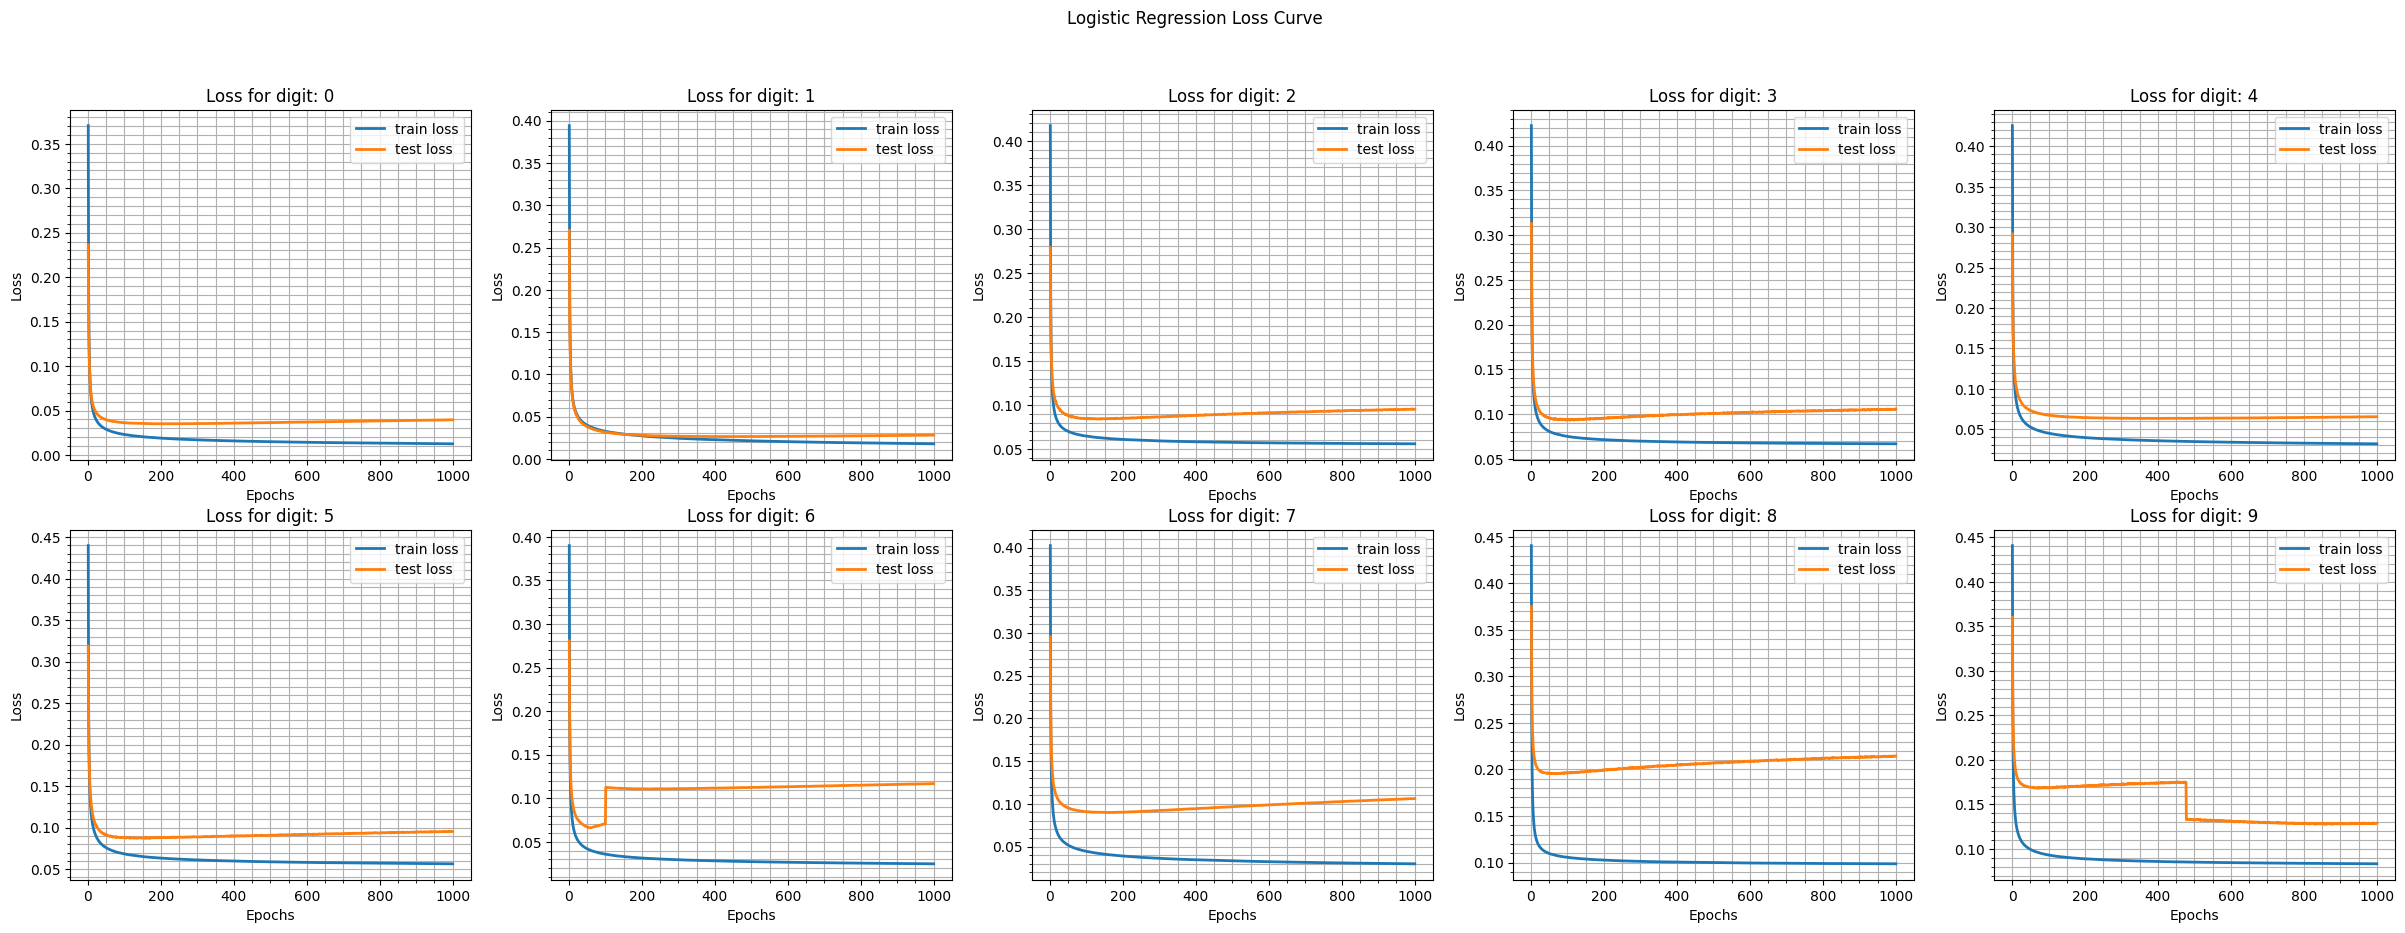

In [47]:
fig, ax = plt.subplots(2, 5, figsize=(30,10), dpi=100)
# Flatten the 2D array of axes for easier indexing
ax = ax.flatten()

for digit in range(10):
    epochs = range(1, len(train_dict[digit]) + 1)
    ax[digit].plot(epochs, train_dict[digit], label = 'train loss', linewidth=2)
    ax[digit].plot(epochs, val_dict[digit], label= 'test loss',  linewidth=2)
    ax[digit].set_xlabel('Epochs')
    ax[digit].set_ylabel('Loss')
    ax[digit].set_title(f'Loss for digit: {digit}')
    ax[digit].legend()
    ax[digit].grid(True, which='both')
    ax[digit].minorticks_on()

fig.suptitle("Logistic Regression Loss Curve")
plt.show()
# fig.savefig("loss_plot_1.jpg, bbox_inches='tight') 

##### Training the logistic regression model for 100 epochs based on train test loss curve above

In [48]:
def train_logistic(train_loader, num_epochs=1000, lr=0.01):
    logistic_model = {}
    train_loss_dict = {}
    for k in range(10):
        print(f"Training classifier for digit {k} vs all...")
    
        # Initialize model, loss, and optimizer
        model = LogisticRegression(785)
        criterion = nn.BCELoss()  # Binary Cross Entropy Loss
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        train_loss = []
                
        # Training loop
        for epoch in range(num_epochs):
            total_train_loss = 0
            for images, labels in train_loader:
                images, labels = images, labels
                # images = flatten_images(images)
                images = torch.cat((torch.ones(images.shape[0], 1), images), dim=1)
    
                # Convert labels to binary: 1 if digit is k, else 0
                binary_labels = (labels == k).float().unsqueeze(1)
    
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, binary_labels)
    
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                
            avg_train_loss = total_train_loss / len(train_loader)
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")
            train_loss.append(avg_train_loss)

        train_loss_dict[k] = train_loss
        logistic_model[k] = model
    return train_loss_dict, logistic_model

In [50]:
train_loss, models = train_logistic(train_loader, num_epochs=1000, lr=0.01)

Training classifier for digit 0 vs all...
Epoch [100/1000], Train Loss: 0.0231
Epoch [200/1000], Train Loss: 0.0190
Epoch [300/1000], Train Loss: 0.0171
Epoch [400/1000], Train Loss: 0.0159
Epoch [500/1000], Train Loss: 0.0150
Epoch [600/1000], Train Loss: 0.0143
Epoch [700/1000], Train Loss: 0.0138
Epoch [800/1000], Train Loss: 0.0133
Epoch [900/1000], Train Loss: 0.0130
Epoch [1000/1000], Train Loss: 0.0126
Training classifier for digit 1 vs all...
Epoch [100/1000], Train Loss: 0.0325
Epoch [200/1000], Train Loss: 0.0270
Epoch [300/1000], Train Loss: 0.0243
Epoch [400/1000], Train Loss: 0.0226
Epoch [500/1000], Train Loss: 0.0213
Epoch [600/1000], Train Loss: 0.0203
Epoch [700/1000], Train Loss: 0.0195
Epoch [800/1000], Train Loss: 0.0188
Epoch [900/1000], Train Loss: 0.0183
Epoch [1000/1000], Train Loss: 0.0178
Training classifier for digit 2 vs all...
Epoch [100/1000], Train Loss: 0.0646
Epoch [200/1000], Train Loss: 0.0609
Epoch [300/1000], Train Loss: 0.0592
Epoch [400/1000], Tra

In [51]:
def test_logistic(models, test_loader):
    # Evaluate on test set
    # model.eval()

    for k in range(10):
        correct = 0
        total = 0
                        
        with torch.no_grad():
            for images, labels in test_loader:
                images = torch.cat((torch.ones(images.shape[0], 1), images), dim=1)
    
                # Convert labels to binary: 1 if digit is k, else 0
                binary_labels = (labels == k).float().unsqueeze(1)
    
                outputs = models[k].forward(images)
                predictions = (outputs >= 0.5).float()
    
                correct += (predictions == binary_labels).sum().item()
                total += labels.size(0)
    
          
        accuracy = (correct / total)
        print(f"Binary Test Accuracy for digit {k}: {accuracy:.4f}")


In [52]:
# Compute Overall Multi-Class Accuracy (based on the highest probability prediction)
def test_logistic_overall(models, test_loader):
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # images = images.view(-1, 784)
            images = torch.cat((torch.ones(images.shape[0], 1), images), dim=1)
            total_samples += labels.size(0)

            # Collect outputs from all 10 perceptrons
            outputs = torch.stack([models[digit](images).squeeze() for digit in range(10)], dim=1)

            # Get the predicted digit (argmax over 10 percpetrons)
            predicted_digits = torch.argmax(outputs, dim=1)

            # Count correct predictions
            total_correct += (predicted_digits == labels).sum().item()

        total_accuracy = total_correct / total_samples
        print(f"Overall Multi-Class Accuracy: {total_accuracy:.4f}")

In [53]:
test_logistic(models, test_loader)

Binary Test Accuracy for digit 0: 0.9875
Binary Test Accuracy for digit 1: 0.9915
Binary Test Accuracy for digit 2: 0.9725
Binary Test Accuracy for digit 3: 0.9680
Binary Test Accuracy for digit 4: 0.9800
Binary Test Accuracy for digit 5: 0.9720
Binary Test Accuracy for digit 6: 0.9780
Binary Test Accuracy for digit 7: 0.9650
Binary Test Accuracy for digit 8: 0.9440
Binary Test Accuracy for digit 9: 0.9620


In [54]:
test_logistic_overall(models, test_loader)

Overall Multi-Class Accuracy: 0.8785
